<div class='alert alert-success'>
    <h1>Qiskit Tutorial, Part 4: Deutsch, Grover, and QFT Algorithms </h1>
    <h4>Yen Lee Loh; started 2023-4-5, edited 2023-4-7 </h4>
</div>

<div class="alert alert-info"><h2>  Setup  </h2></div>

This is a Markdown cell with LaTeX definitions.  Please run it.
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$

In [2]:
import numpy as np; from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import qiskit,qiskit_aer
import qiskit.visualization as qisvis
from qiskit.providers.fake_provider import fake_provider
vigoBackend = fake_provider.FakeVigo()
rng = random.default_rng()

def toBitString(integer, numBits): return bin(integer)[2:].zfill(numBits)
def plotStateVector(psi,ax,cmap=mpl.cm.hsv):
  nmax = int(np.log(len(psi)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  probs = np.abs(psi)**2
  phases = np.remainder(np.angle(psi) / (2*np.pi), 1)
  for l in range(lmax):
    patch = patches.Rectangle([l,0], 1,probs[l], ec='black', fc=cmap(phases[l]))
    ax.add_patch(patch)
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, max(probs)*1.1)
def padCounts(cts, numBits):
  def sanitize(count): return (0 if count==None else count)
  n = numBits
  return {toBitString(i,n):sanitize(cts.get(toBitString(i,n))) for i in range(2**n)}
def plotHistogram(counts,ax,fc='#9cf',textrot=0):
  if isinstance (counts, dict):
    nmax = len(list(counts.keys()) [0] )  # ugly
    counts = padCounts(counts,nmax)
    counts = list(counts.values())
  nmax = int(np.log(len(counts)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  ymax = max(counts)
  for l in range(lmax):
    c = counts[l]
    patch = patches.Rectangle([l,0], 1,c, ec='black', fc=fc)
    ax.add_patch(patch)
    if c>0:
      y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
      ax.text (l+.5, y, c, va='center',ha='center')
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])  
  ax.tick_params(axis='x', labelrotation=textrot)
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, ymax*1.02)

sim = qiskit_aer.AerSimulator()                         # run this line if you want to use ideal simulator

#sim = qiskit_aer.AerSimulator.from_backend(vigoBackend) # uncomment and run if you want to use a noisy simulator based on IBM's Vigo machine

<div class="alert alert-info"><h2>  Deutsch algorithm  </h2></div>

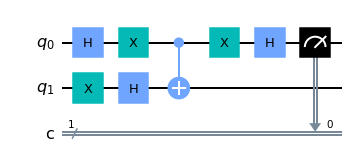

Oracle                        f(0)=1, f(1)=0
Constant(0) or balanced(1)    1
Deutsch algorithm output      {'1': 100}

The above code randomly chooses the oracle from 4 possibilities.
The output of the Deutsch algorithm should match the oracle type 100% of the time.


In [3]:
oracle = rng.integers(4)      # oracle=2 means f(0)=1 and f(1)=0; oracle=3 means f(0)=1 and f(1)=1
#======== Apply H0,X1,H1 
cir = qiskit.QuantumCircuit(2,1)
cir.h(0); cir.x(1); cir.h(1)
#======== Consult oracle
if oracle==0: pass            # oracle output is always 0, so nothing happens
if oracle==1: cir.cx(0,1)     # oracle returns f(x)=x, so this is a regular CNOT gate
if oracle==2: cir.x(0); cir.cx(0,1); cir.x(0); # oracle returns f(x)=1-x
if oracle==3: cir.x(1)        # oracle output is always 1, so output qubit gets flipped
#======== Apply H0,M0
cir.h(0)
cir.measure([0],[0])
#======== Draw circuit
display( cir.draw('mpl') ) 
#======== Test circuit
exe=qiskit.transpile(cir,sim); job=sim.run(exe,shots=100); res=job.result(); cts=res.get_counts(exe)
print(f'Oracle                        f(0)={oracle>>1}, f(1)={oracle&1}')
print(f'Constant(0) or balanced(1)    {1 if oracle==1 or oracle==2 else 0}')
print(f'Deutsch algorithm output      {cts}')
print(f'\nThe above code randomly chooses the oracle from 4 possibilities.\nThe output of the Deutsch algorithm should match the oracle type 100% of the time.')

<div class="alert alert-info"><h2>  Grover algorithm  </h2></div>

In [20]:
def ccccnot(c): # 0123=input, 4=input, 5=ancilla
  c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(3,5,4)
  c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(0,1,4); c.ccx(2,4,5); c.ccx(3,5,4)
def oracle(c):
  c.x(0);c.x(3);ccccnot(c);c.x(0);c.x(3)    # this is deliberately opaque
def grover(c):
  c.h(0);c.h(1);c.h(2);c.h(3);              # transform into Walsh basis
  c.x(0);c.x(1);c.x(2);c.x(3); ccccnot(c)   # flip bit 4 only if bits 0-3 are 0000 
  c.x(0);c.x(1);c.x(2);c.x(3);              # uncompute
  c.h(0);c.h(1);c.h(2);c.h(3);              # transform back
def groverDemo(iterations=1):
  cir = qiskit.QuantumCircuit(6,4)
  cir.h(0);cir.h(1);cir.h(2);cir.h(3)    # initialize to Grover state
  for i in range(iterations):
    oracle(cir); grover(cir)             # apply oracle (F) and grover (G)
  cir.measure([0,1,2,3],[0,1,2,3])
  exe=qiskit.transpile(cir,sim); job=sim.run(exe,shots=100); res=job.result(); cts=res.get_counts(exe)
  fig,axs = plt.subplots(1,2,figsize=(20,2))
  cir.draw('mpl',fold=-1,ax=axs[0])
  qisvis.plot_histogram(cts,ax=axs[1])

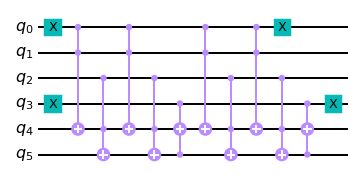

In [42]:
#===============================================================
# The circuit below implements an oracle function gate F,
# where F flips q4 for a particular combination of q0,q1,q2,q3.
# It's not obvious what that combination is!
#===============================================================
cir = qiskit.QuantumCircuit(6); oracle(cir); fig,ax=plt.subplots(1,1,figsize=(12,3)); cir.draw('mpl',ax=ax)

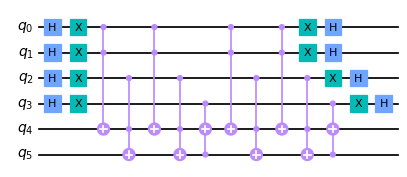

In [43]:
#===============================================================
# The circuit below performs the Grover operation G = W F_0 W
# where W is a Walsh transform and F_0 flips q4 if q0=q1=q2=q3=0.
#===============================================================
cir = qiskit.QuantumCircuit(6); grover(cir); fig,ax=plt.subplots(1,1,figsize=(12,3)); cir.draw('mpl',ax=ax)

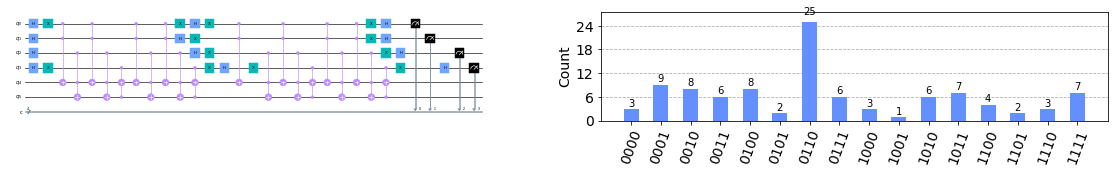

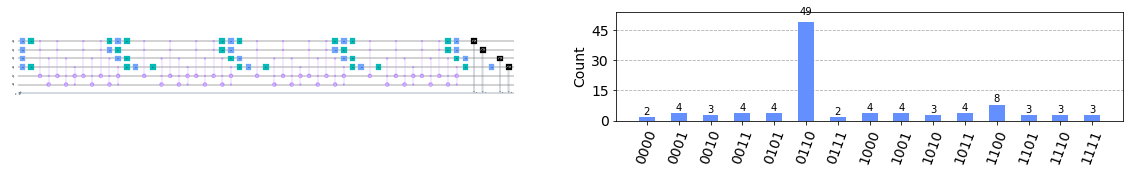

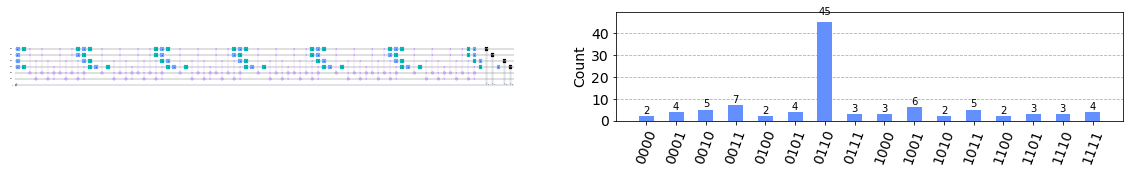

In [44]:
#===============================================================
# The function groverDemo(...) applies Grover's algorithm:
# 1. Apply a Hadamard gate to each input qubit.  
#    This sets the statevector to |g>.
# 2. Apply the operator R=GF several times.  
#    This operator rotates the statevector from |g> toward |f>.
# 3. Measure all input qubits.
#===============================================================
groverDemo(iterations=1)
groverDemo(iterations=2)
groverDemo(iterations=3)

The demo above shows that for a 4-bit oracle, 3 iterations of Grover's algorithm give us the correct answer about 50% of the time.

<div class="alert alert-info"><h2>  Quantum Fourier transform starting from one basis state  </h2></div>

psi =  [ 2.50e-01-3.06e-17j  1.77e-01+1.77e-01j  7.85e-17+2.50e-01j -1.77e-01+1.77e-01j -2.50e-01+3.93e-17j -1.77e-01-1.77e-01j -9.81e-17-2.50e-01j  1.77e-01-1.77e-01j  2.50e-01-3.06e-17j
  1.77e-01+1.77e-01j  7.85e-17+2.50e-01j -1.77e-01+1.77e-01j -2.50e-01+3.93e-17j -1.77e-01-1.77e-01j -9.81e-17-2.50e-01j  1.77e-01-1.77e-01j]


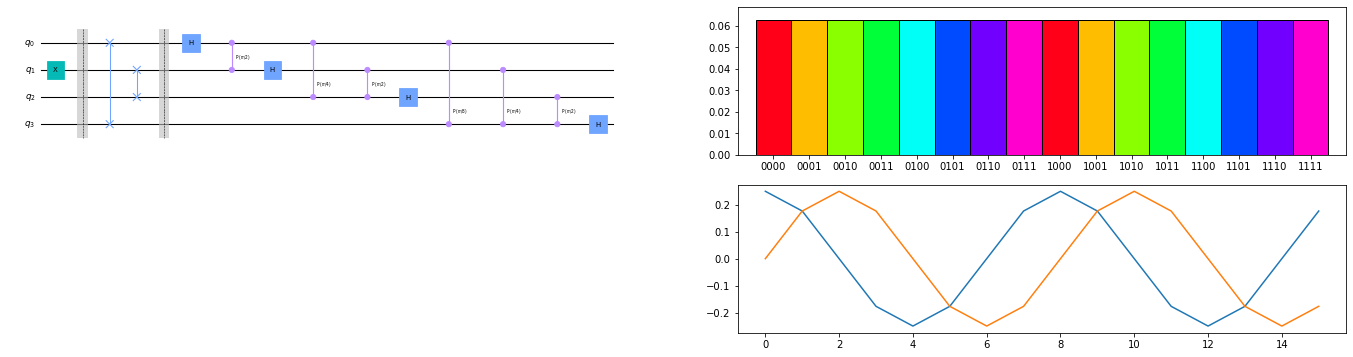

In [18]:
initialState = 2   # change this if you like to any number between 0 and 15 inclusive
#======== Set up
cir = qiskit.QuantumCircuit(4)
initState (cir, value=initialState, numBits=4)   # init statevector
cir.barrier()
cir.swap(0,3); cir.swap(1,2)                     # Bit-reversal permutation
cir.barrier()
#======== Quantum Fourier transform
cir.h(0); cir.cp(np.pi/2, 1,0); cir.cp(np.pi/4, 2,0); cir.cp(np.pi/8, 3,0)
cir.h(1); cir.cp(np.pi/2, 2,1); cir.cp(np.pi/4, 3,1)
cir.h(2); cir.cp(np.pi/2, 3,2)
cir.h(3)
#======== Draw circuit
fig,axs = plt.subplots(2,2,figsize=(24,6)); axs[1,0].axis('off')
cir.draw('mpl',justify='none',fold=-1,ax=axs[0,0])
#======== Execute the quantum circuit on a statevector simulator
sim = qiskit.BasicAer.get_backend('statevector_simulator')
exe = qiskit.transpile(cir, sim)
job = sim.run(exe)
res = job.result()
psi = res.get_statevector(cir)
np.set_printoptions(precision=2,linewidth=200); print ('psi = ', np.array(psi))
#======== Visualize the statevector in various ways
plotStateVector(psi,ax=axs[0,1])
ax=axs[1,1]
ax.plot (np.real(psi))
ax.plot (np.imag(psi));

<div class="alert alert-info"><h2>  Quantum Fourier transform starting from superposition of two basis states  </h2></div>

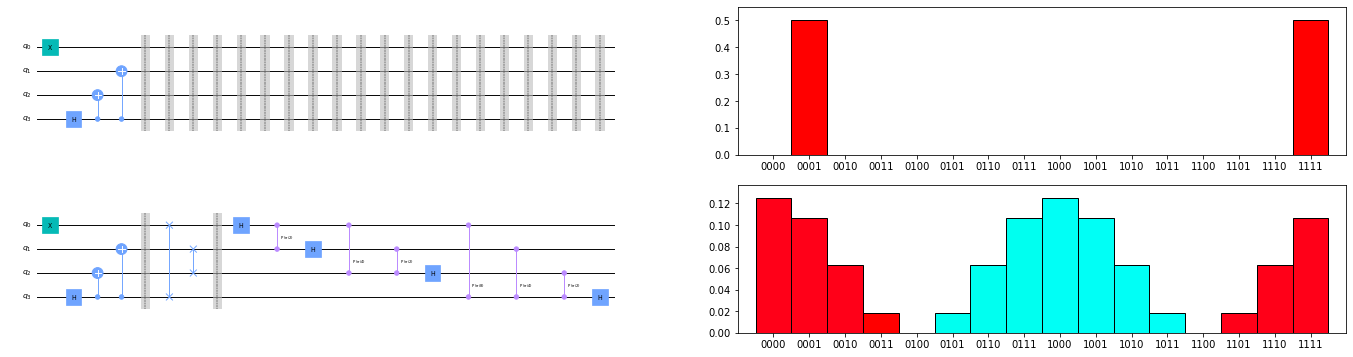

In [19]:
def initStates(cir,vals):
  if vals==0:        pass
  elif vals==1:      cir.x(0) 
  elif vals=='all':  cir.h(0); cir.h(1); cir.h(2); cir.h(3)
  elif vals==[1,15]: cir.h(3); cir.cx(3,2); cir.cx(3,1); cir.x(0)
  elif vals==[2,14]: cir.h(3); cir.cx(3,2); cir.x(1)
  elif vals==[3,13]: cir.h(3); cir.cx(3,2); cir.cx(3,1); cir.x(1); cir.x(0)
  elif vals==[4,12]: cir.h(3); cir.x(2)
  
def myInit(cir):   initStates(cir,[1,15])

sim = qiskit.BasicAer.get_backend('statevector_simulator')
fig,axs = plt.subplots(2,2,figsize=(24,6)); axs[1,0].axis('off')
#======== Calculate initial state
cir = qiskit.QuantumCircuit(4)
myInit(cir)
[cir.barrier() for i in range(20)]
cir.draw('mpl',justify='none',fold=-1,ax=axs[0,0])
psi = sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir)
plotStateVector (psi,ax=axs[0,1])
#======== Calculate final state
cir = qiskit.QuantumCircuit(4)
myInit(cir)
cir.barrier()
cir.swap(0,3); cir.swap(1,2)                     # Bit-reversal permutation
cir.barrier()
#======== Quantum Fourier transform
cir.h(0); cir.cp(np.pi/2, 1,0); cir.cp(np.pi/4, 2,0); cir.cp(np.pi/8, 3,0)
cir.h(1); cir.cp(np.pi/2, 2,1); cir.cp(np.pi/4, 3,1)
cir.h(2); cir.cp(np.pi/2, 3,2)
cir.h(3)
cir.draw('mpl',justify='none',fold=-1,ax=axs[1,0])
psi = sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir)
plotStateVector(psi,ax=axs[1,1])

<div class="alert alert-info"><h2>  Quantum Fourier transform from library  </h2></div>

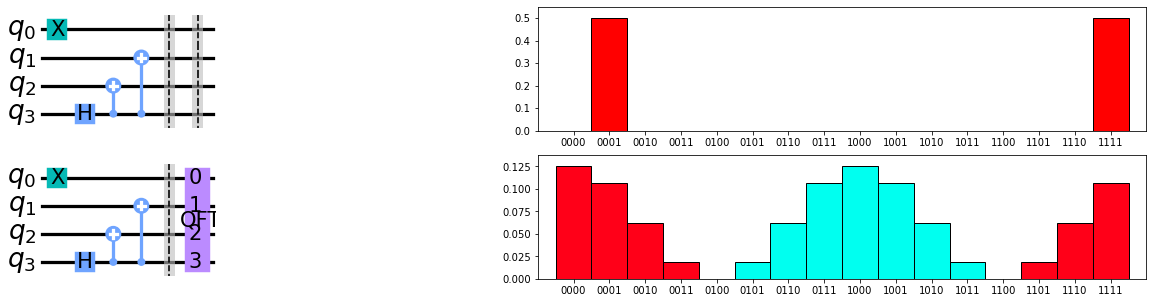

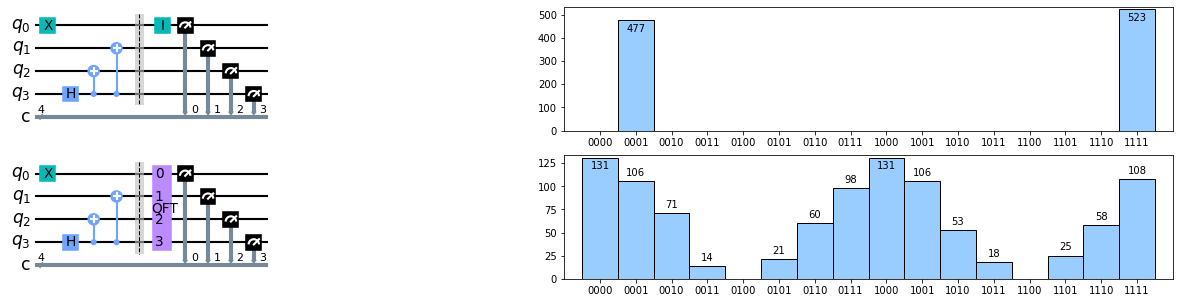

In [157]:
sim = qiskit.BasicAer.get_backend('statevector_simulator')
fig,axs = plt.subplots(2,2,figsize=(24,5))
#======== Calculate initial state
cir = qiskit.QuantumCircuit(4)
myInit(cir)
[cir.barrier() for i in range(2)]
cir.draw('mpl',justify='none',fold=-1,ax=axs[0,0])
psi = sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir)
plotStateVector (psi,ax=axs[0,1])
#======== Calculate final state
cir = qiskit.QuantumCircuit(4)
myInit(cir)
cir.barrier()
cir.append(qiskit.circuit.library.QFT(4), [0,1,2,3])          # 4-qubit quantum Fourier transform
cir.draw('mpl',justify='none',fold=-1,ax=axs[1,0])
psi = sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir)
plotStateVector(psi,ax=axs[1,1])

sim = qiskit_aer.AerSimulator()
fig,axs = plt.subplots(2,2,figsize=(24,5))
#======== Calculate initial state
cir = qiskit.QuantumCircuit(4,4)
myInit(cir)
cir.barrier()
cir.i(0)
cir.measure([0,1,2,3],[0,1,2,3])
cir.draw('mpl',justify='none',fold=-1,ax=axs[0,0])
cts = sim.run(qiskit.transpile(cir,sim),shots=1000).result().get_counts(cir)
cts = padCounts(cts,4)
plotHistogram(list(cts.values()), ax=axs[0,1])# qisvis.plot_histogram(cts, ax=axs[0,1])
#======== Calculate final state
cir = qiskit.QuantumCircuit(4,4)
myInit(cir)
cir.barrier()
cir.append(qiskit.circuit.library.QFT(4), [0,1,2,3])          # 4-qubit quantum Fourier transform
cir.measure([0,1,2,3],[0,1,2,3])
cir.draw('mpl',justify='none',fold=-1,ax=axs[1,0])
cts = sim.run(qiskit.transpile(cir,sim),shots=1000).result().get_counts(cir)
cts = padCounts(cts,4)
plotHistogram(list(cts.values()), ax=axs[1,1])

In [83]:
# qisvis.plot_histogram(cts)